In [40]:
import json
import numpy as np 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from Utilities import Add_ID_Count_Neighbours

import torch
import torch.nn as nn
from torch import Tensor

from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from training import training_loop

In [2]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

In [3]:
class TripletData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_1':
            return self.x_1.size(0)
        if key == 'edge_index_2':
            return self.x_2.size(0)
        if key == 'edge_index_3':
            return self.x_3.size(0)
        return super().__inc__(key, value, *args, **kwargs)

In [4]:
scaling = 'counts'
dist = 'L1'
scale_y = True

with open('data/homomorphism_counts/ENZYMES_44.homson') as f:
    data = json.load(f)
    if scaling == 'counts':
        hom_counts = [element['counts'] for element in data['data']]
    else:
        raise NotImplementedError('Scaling not implemented')

# Compute the distance matrix
if dist == 'L1':
    dist_matrix = cdist(hom_counts, hom_counts, metric='cityblock')
elif dist == 'L2':
    dist_matrix = cdist(hom_counts, hom_counts, metric='euclidean')
elif dist == 'cosine':
    dist_matrix = cdist(hom_counts, hom_counts, metric='cosine')

dist_matrix = dist_matrix.astype('float32')

if scale_y:
    dist_matrix = np.sqrt(dist_matrix)
    # ADDITIONALLY HERE RESCALE FOR DISTANCES TO BE IN [0, 1]
    dist_matrix = dist_matrix / np.max(dist_matrix)

In [64]:
# Obtain train/validation-test split. For validation and train consider subsets of the created triplets.
dataset = dataset.shuffle()
train_val_dataset = dataset[:int(0.8*len(dataset) + 1)]
test_dataset = dataset[int(0.8*len(dataset) + 1):]

In [42]:
k = 50
# Extract distances between homomorphism counts cause we need them (consider the rescaled ones as before as they might help.)
data_list = []
for a_index, a_graph in enumerate(dataset):
    a_id = a_graph['id']
    # Obtain k closest graphs
    closest = np.argsort(dist_matrix[a_id])[0:k+1]
    closest = np.delete(closest, np.where(closest == int(a_id)))

    # Obtain k furthest away graphs
    farthest = np.argsort(dist_matrix[a_id])[-k:]
    
    # Sample entries for the positive and negative pairs at random (without replacement).
    while len(closest) != 0:
        p_id = np.random.choice(closest)
        n_id = np.random.choice(farthest)
        closest = np.delete(closest, np.where(closest == p_id))
        farthest = np.delete(farthest, np.where(farthest == n_id))

        p_graph = dataset[p_id]
        n_graph = dataset[n_id]

        # Obtain the margin to assign between the two
        margin = torch.from_numpy(np.asarray(dist_matrix[a_id, n_id] - dist_matrix[a_id, p_id]))

        # Create the triplet 
        data_list.append(TripletData(x_1=a_graph.x, edge_index_1=a_graph.edge_index,
                                        x_2=p_graph.x, edge_index_2=p_graph.edge_index,
                                        x_3=n_graph.x, edge_index_3=n_graph.edge_index,
                                        margin=margin))

In [43]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
batch_size = 32
# Prepare batch
loader = DataLoader(data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2', 'x_3'], shuffle=True)

In [44]:
"""
This file contains the implementation of the different classes considered.
"""
import torch
from torch.nn import Linear, Parameter, PairwiseDistance, CosineSimilarity
from torch_geometric.nn import MessagePassing, global_mean_pool, GCNConv
from torch_geometric.nn.norm import BatchNorm

class GCN_k_m(torch.nn.Module):
    """
    Takes as input a pair of graphs which are both fed through k graph convolutional layers and m linear layers (with k >= 1 and m >= 0).
    conv1 -> relu -> ... -> convk -> meanpool -> compute dist(x1, x2)
    If a number of linear layers m >= 1 is specified:
    conv1 -> ...         -> convk -> meanpool -> linear1 -> relu -> ... -> linearm -> compute dist(x1, x2)
    
    If mlp_dist is set to True:
    The distance between the two embedding vectors is obtained by applying a linear transformation on the difference between the two.
    """
    def __init__(self, input_features, hidden_channels, output_embeddings, n_conv_layers, n_linear_layers, name, dist = 'L1'):
        super(GCN_k_m, self).__init__()

        if n_conv_layers < 1:
            raise ValueError("Invalid value for n_conv_layers. n_conv_layers should be an integer larger than 0")
        if dist not in ['cosine', 'L1', 'L2']:
            raise ValueError("Invalid value for 'dist'. Expected 'cosine', 'L1', or 'L2'.")
        
        # Details for the architecture
        self.dist = dist
        self.input_features = input_features
        self.output_embeddings = output_embeddings 
        self.name = name

        # Hyper-parameters.
        # self.apply_relu_conv = apply_relu_conv # If True applies relu after each convolutional layer
        self.hidden_channels = hidden_channels # Sets dimension of hidden channels
        self.n_conv_layers = n_conv_layers     # Sets number of convolutional layers.
        self.n_linear_layers = n_linear_layers # Sets number of linear layers.

        # GCN and Linear layers employed by the model.
        self.GCN_layers = torch.nn.ModuleList()
        self.Linear_layers = torch.nn.ModuleList()
        self.BN_layers = torch.nn.ModuleList()

        # If no linear layers
        if self.n_linear_layers == 0:
            for i in range(self.n_conv_layers-1): 
                self.GCN_layers.append(GCNConv(input_features, hidden_channels))
                input_features = hidden_channels # From second layer we'll need this.
            # Final GCN layer
            self.GCN_layers.append(GCNConv(input_features, output_embeddings))

        # If there are some linear layers
        else:
            for i in range(self.n_conv_layers): 
                self.GCN_layers.append(GCNConv(input_features, hidden_channels))
                input_features = hidden_channels # From second layer we'll need this.
            # Linear layers
            for i in range(self.n_linear_layers - 1):
                self.Linear_layers.append(Linear(hidden_channels, hidden_channels))
            # Final linear layer
            self.Linear_layers.append(Linear(hidden_channels, output_embeddings))

        # Prepare batch normalization layers to apply after each convolutonal layer.
        for i in range(self.n_conv_layers-1):
            self.BN_layers.append(BatchNorm(hidden_channels))

        # Additional layers
        self.relu = torch.nn.ReLU()
        
        # Define the operation to be performed on the distances based on the the specification.
        if self.dist == 'L1':
            self.pdist = PairwiseDistance(p=1)
        elif self.dist == 'L2':
            self.pdist = PairwiseDistance(p=2)
        elif self.dist == 'cosine':
            self.pdist = CosineSimilarity()

    def forward_base_network(self, x, edge_index, batch):  # This is the forward pass for the base network. 
        # 1. Obtain node embeddings for graph 1 and 2
        for i, gcn_layer in enumerate(self.GCN_layers):
            x = gcn_layer(x, edge_index)
    
            if i != (self.n_conv_layers-1): # Do not apply batch normalization or ReLu after the last convolutional layer.
                x = self.relu(x)
                x = self.BN_layers[i](x) 
        
        # 2. Readout layer followed by Linear layers.
        x = global_mean_pool(x, batch)
        x = torch.nn.functional.dropout(x, p=0.5)

        for i, layer in enumerate(self.Linear_layers):
            x = layer(x)
            if i != self.n_linear_layers: # Do not apply ReLu after the final linear layer
                x = self.relu(x)
        return x

    def forward_contrastive_loss(self, x1, edge_index1, batch1, x2, edge_index2, batch2): # Forward pass when two inputs are given to the network
        x1 = self.forward_base_network(x1, edge_index1, batch1)
        x2 = self.forward_base_network(x2, edge_index2, batch2)

        # Compute the corresponding distance between the embeddings.
        if self.dist == 'cosine':
            vdist = 1 - self.pdist(x1, x2)
        else:
            vdist = self.pdist(x1, x2)
        return vdist

    def forward_triplet_loss(self, x1, edge_index1, batch1, x2, edge_index2, batch2, x3, edge_index3, batch3): # Forward pass when three inputs are given to the network
        x1 = self.forward_base_network(x1, edge_index1, batch1)
        x2 = self.forward_base_network(x2, edge_index2, batch2)
        x3 = self.forward_base_network(x3, edge_index3, batch3)

        return x1, x2, x3

    def forward(self, x1, edge_index1, batch1, x2, edge_index2, batch2, x3=None, edge_index3=None, batch3=None):
        if x3 is None:
            # Call Contrastive loss forward.
            return self.forward_contrastive_loss(x1, edge_index1, batch1, x2, edge_index2, batch2)  
        else:
            # Call triplet loss forward.
            return self.forward_triplet_loss(x1, edge_index1, batch1, x2, edge_index2, batch2, x3, edge_index3, batch3)

    def save(self):
        """
        Saves the model state dictionary in models folder
        """
        path = 'models/' + self.name + '.pt'
        torch.save(self.state_dict(), path)

In [45]:
class CustomTripletMarginLoss(torch.nn.Module):
    __constants__ = [ 'p']
    p: float

    def __init__(self, p: float = 2.):
        super(CustomTripletMarginLoss, self).__init__()
        self.p = p

    def forward(self, anchor: Tensor, positive: Tensor, negative: Tensor, margin: Tensor) -> Tensor:
        d_ap = torch.norm(anchor - positive, dim=1, p=self.p)
        d_an = torch.norm(anchor - negative, dim=1, p=self.p)
        losses = torch.nn.functional.relu(d_ap - d_an + margin, inplace=False) # Remove all entries smaller than 0.
        return losses.mean()

In [46]:
lr = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=32, output_embeddings=44, n_conv_layers=2, n_linear_layers=0, name='test_triplet', dist='L1')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = CustomTripletMarginLoss(p=2).to(device)

In [47]:
# k = 50
train_losses, validation_losses = training_loop(model, loader, optimizer, criterion, loader, epoch_number=50, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 5m 59s
	Train Loss: 0.342
	 Val. Loss: 0.075
Epoch: 20 | Time for 10 epochs: 6m 24s
	Train Loss: 0.340
	 Val. Loss: 0.089
Early stopping triggered at epoch 20
Best epoch was 9


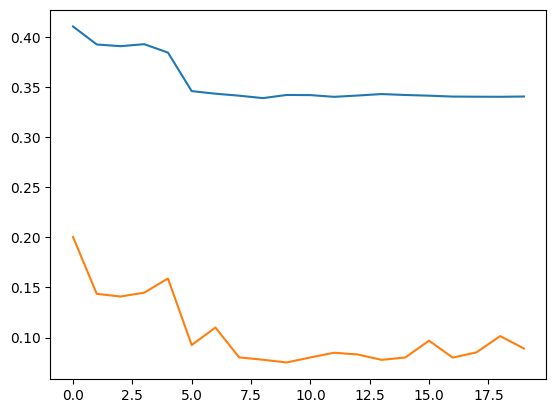

In [48]:
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation') 

In [38]:
# k = 20
train_losses, validation_losses = training_loop(model, loader, optimizer, criterion, loader, epoch_number=50, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 3m 4s
	Train Loss: 0.532
	 Val. Loss: 0.152
Early stopping triggered at epoch 13
Best epoch was 2


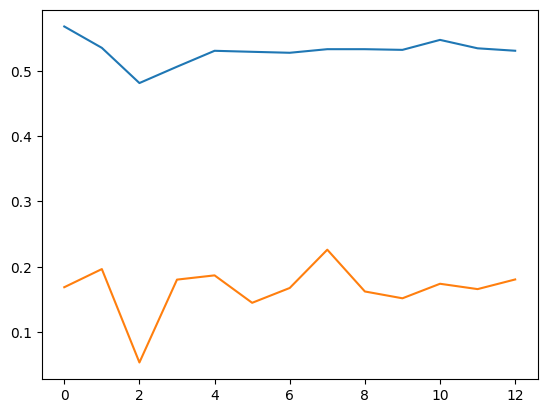

In [41]:
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation') 

In [32]:
# k = 15
train_losses, validation_losses = training_loop(model, loader, optimizer, criterion, loader, epoch_number=50, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 1m 37s
	Train Loss: 0.578
	 Val. Loss: 0.223
Early stopping triggered at epoch 15
Best epoch was 4


In [26]:
# k = 10
train_losses, validation_losses = training_loop(model, loader, optimizer, criterion, loader, epoch_number=50, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 1m 4s
	Train Loss: 0.646
	 Val. Loss: 0.311
Early stopping triggered at epoch 14
Best epoch was 3


## USING ALL BUNCH OF TRIPLETS

In [58]:
k = 5
# Extract distances between homomorphism counts cause we need them (consider the rescaled ones as before as they might help.)
data_list = []
for a_index, a_graph in enumerate(dataset):
    a_id = a_graph['id']
    # Obtain k closest graphs
    closest = np.argsort(dist_matrix[a_id])[0:k+1]
    closest = np.delete(closest, np.where(closest == int(a_id)))

    # Obtain k furthest away graphs
    farthest = np.argsort(dist_matrix[a_id])[-k:]
    
    # Sample entries for the positive and negative pairs at random 
    for p_id in closest:
        p_graph = dataset[p_id]
        for n_id in farthest:
            n_graph = dataset[n_id]
            # Obtain the margin to assign between the two 
            margin = torch.from_numpy(np.asarray(dist_matrix[a_id, n_id] - dist_matrix[a_id, p_id]))
            data_list.append(TripletData(x_1=a_graph.x, edge_index_1=a_graph.edge_index,
                                        x_2=p_graph.x, edge_index_2=p_graph.edge_index,
                                        x_3=n_graph.x, edge_index_3=n_graph.edge_index,
                                        margin=margin))

In [59]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
batch_size = 32
# Prepare batch
loader = DataLoader(data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2', 'x_3'], shuffle=True)

In [60]:
lr = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=32, output_embeddings=44, n_conv_layers=2, n_linear_layers=0, name='test_triplet', dist='L1')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = CustomTripletMarginLoss(p=2).to(device)

In [61]:
# k = 20
train_losses, validation_losses = training_loop(model, loader, optimizer, criterion, loader, epoch_number=20, patience=5, return_losses=True)

Epoch: 10 | Time for 10 epochs: 3m 13s
	Train Loss: 0.525
	 Val. Loss: 0.033
Early stopping triggered at epoch 11
Best epoch was 5


- - - 

In [10]:
model.eval()
with torch.no_grad():
    for batch in loader:
        anchor, positive, negative = model(batch.x_1.float(), batch.edge_index_1, batch.x_1_batch,
                           batch.x_2.float(), batch.edge_index_2, batch.x_2_batch,
                           batch.x_3.float(), batch.edge_index_3, batch.x_3_batch)

In [17]:
a = torch.randn(100, 44, requires_grad=True)
p = torch.randn(100, 44, requires_grad=True)
n = torch.randn(100, 44, requires_grad=True)
margin = torch.randn(100, requires_grad=True)

In [18]:
class CustomTripletMarginLoss(torch.nn.Module):
    __constants__ = [ 'p']
    p: float

    def __init__(self, p: float = 2.):
        super(CustomTripletMarginLoss, self).__init__()
        self.p = p

    def forward(self, anchor: Tensor, positive: Tensor, negative: Tensor, margin: Tensor) -> Tensor:
        d_ap = torch.norm(a - p, dim=1, p=self.p)
        d_an = torch.norm(a - n, dim=1, p=self.p)
        losses = torch.nn.functional.relu(d_ap - d_an + margin, inplace=False) # Remove all entries smaller than 0.
        print(losses)
        return losses.mean()

In [19]:
triplet_loss = CustomTripletMarginLoss(p=2)

In [21]:
triplet_loss(a, p, n, margin)

tensor([1.7241, 0.8844, 0.1229, 2.1568, 0.0000, 0.0000, 0.4302, 1.7382, 0.0000,
        1.5834, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2546, 2.3055, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1404, 0.0000, 0.0000, 3.1657, 0.2228, 2.6370,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4558, 0.6973, 0.0000, 0.0000,
        1.2245, 0.0000, 0.0000, 0.0000, 1.1430, 0.0000, 0.8623, 0.6163, 0.0000,
        0.7579, 0.7639, 0.5172, 0.0000, 0.0000, 1.7816, 1.7591, 2.9611, 0.0000,
        1.7274, 0.3970, 0.0000, 1.2914, 0.0000, 0.1768, 0.0000, 0.0000, 0.0000,
        0.0000, 4.1160, 1.2337, 0.8383, 1.3015, 0.0000, 0.0000, 0.0000, 0.7484,
        0.1275, 0.1616, 3.4277, 0.3994, 0.0000, 1.6854, 0.0000, 1.5949, 0.0000,
        0.0000, 0.0832, 0.0000, 0.9760, 0.0000, 2.2489, 0.0000, 0.3684, 0.0000,
        0.0000, 2.9536, 0.0000, 0.8067, 0.0000, 0.0000, 1.9480, 0.0000, 0.0000,
        0.0000], grad_fn=<ReluBackward0>)


tensor(0.6252, grad_fn=<MeanBackward0>)